In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [36]:
stock_data = pd.read_csv('../data/stock_data_eda.csv')

In [37]:
X = stock_data[['Open', 'Low', 'High', 'Volume']].values  
y = stock_data['Close'].values 

In [38]:
data = pd.get_dummies(stock_data, drop_first=True, dtype=int)
data.head()

,Open,High,Low,Close,Volume,OpenInt,Change,Loss,Average,Daily Return,...,Date_2017-11-02,Date_2017-11-03,Date_2017-11-06,Date_2017-11-07,Date_2017-11-08,Date_2017-11-09,Date_2017-11-10,Stock_META,Stock_MSFT,Stock_TSLA
0,0.42516,0.43668,0.42516,0.42902,42498199,0,0.00386,-0.00386,0.430920,0.001164,...,0,0,0,0,0,0,0,0,0,0
1,0.47512,0.47512,0.45335,0.45335,146978950,0,-0.02177,0.02177,0.464235,0.056711,...,0,0,0,0,0,0,0,0,0,0
2,0.32911,0.32911,0.30733,0.30733,91968038,0,-0.02178,0.02178,0.318220,-0.322091,...,0,0,0,0,0,0,0,0,0,0
3,0.33041,0.33297,0.32911,0.32911,33621242,0,-0.00130,0.00130,0.331040,0.070868,...,0,0,0,0,0,0,0,0,0,0
4,0.27279,0.27535,0.27279,0.27279,68760507,0,0.00000,0.00000,0.274070,-0.171128,...,0,0,0,0,0,0,0,0,0,0


In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,  
    test_size=0.3,  # 30% for testing
    random_state=42,
    shuffle=False   # Do not shuffle the data
)

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor


models = {
    "Gradient Boosting": GradientBoostingRegressor(),
    "kNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(
        n_estimators=600,
        max_depth=100,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=1
    )
}



In [42]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({
        'Model': name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse
    })

    print(f"{name} R²: {r2:.2f}")
    print(f"{name} MAE: {mae:.2f}")
    print(f"{name} MSE: {mse:.2f}")
    print(f"{name} RMSE: {rmse:.2f}")
    print("-" * 40)

results_df = pd.DataFrame(results)

Gradient Boosting R²: 0.78
Gradient Boosting MAE: 21.91
Gradient Boosting MSE: 2206.84
Gradient Boosting RMSE: 46.98
----------------------------------------
kNN R²: -0.04
kNN MAE: 79.05
kNN MSE: 10378.75
kNN RMSE: 101.88
----------------------------------------
Random Forest R²: 0.77
Random Forest MAE: 22.53
Random Forest MSE: 2301.01
Random Forest RMSE: 47.97
----------------------------------------


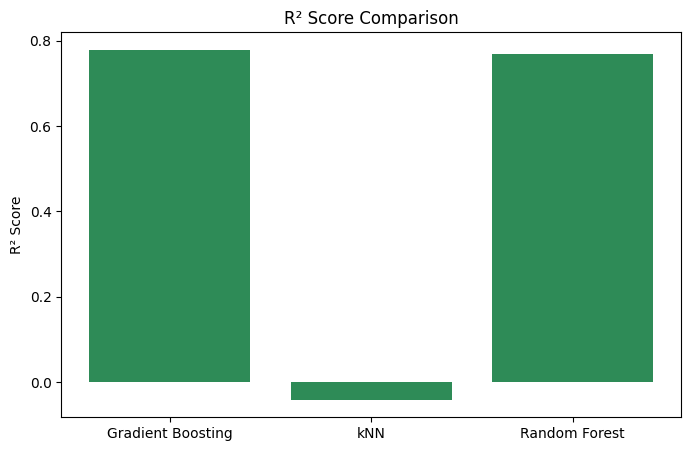

In [43]:
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['R²'], color='seagreen')
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.show()

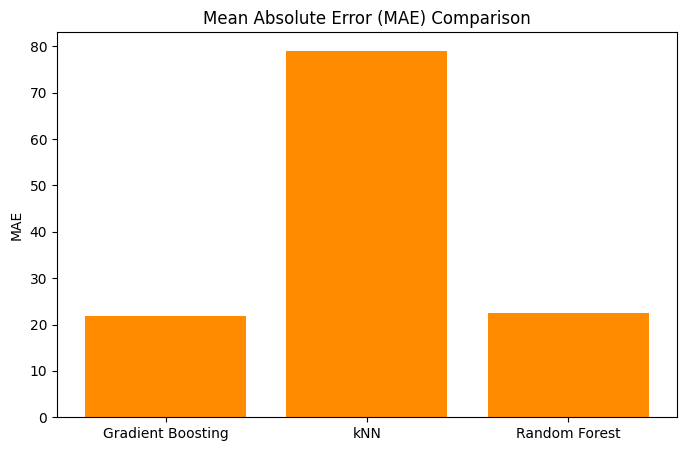

In [44]:
# Plot MAE
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['MAE'], color='darkorange')
plt.title("Mean Absolute Error (MAE) Comparison")
plt.ylabel("MAE")
plt.show()

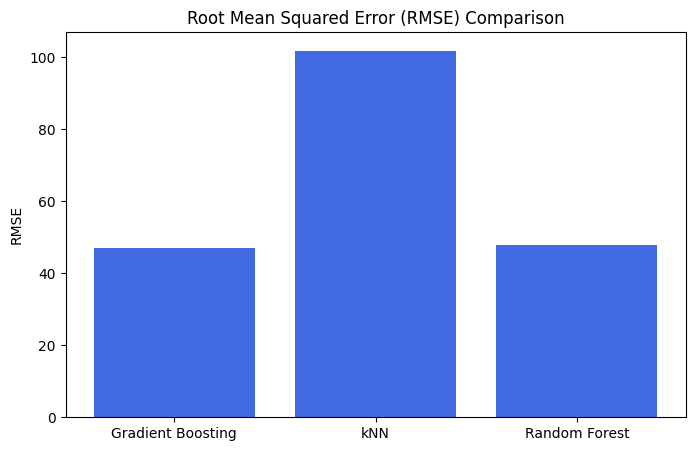

In [45]:
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['RMSE'], color='royalblue')
plt.title("Root Mean Squared Error (RMSE) Comparison")
plt.ylabel("RMSE")
plt.show()

In [46]:
from sklearn.pipeline import Pipeline
# Define pipelines for scaling + model
pipelines = {
    'kNN': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor())
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),  
        ('rf', RandomForestRegressor(random_state=1))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),  
        ('gb', GradientBoostingRegressor(random_state=1))
    ])
}

In [47]:
param_grids = {
    'kNN': {
        'knn__n_neighbors': [3, 5, 7, 10],
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2]  
    },
    'Random Forest': {
        'rf__n_estimators': [100, 300, 600],
        'rf__max_depth': [20, 50, 100],
        'rf__min_samples_split': [2, 10],
        'rf__min_samples_leaf': [1, 4]
    },
    'Gradient Boosting': {
        'gb__n_estimators': [100, 300, 600],
        'gb__learning_rate': [0.01, 0.1],
        'gb__max_depth': [3, 5, 10]
    }
}

In [48]:
results = []

for name in ['kNN', 'Random Forest', 'Gradient Boosting']:
    print(f"Result of {name}:")
    grid_search = GridSearchCV(
        pipelines[name],
        param_grid=param_grids[name],
        cv=3,  
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"{name} R²: {r2:.2f}")
    print(f"{name} MAE: {mae:.2f}")
    print(f"{name} RMSE: {rmse:.2f}")
    print("-" * 40)

    results.append({
        'Model': name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Best Params': grid_search.best_params_
    })

results_df = pd.DataFrame(results)

Result of kNN:


Best params for kNN: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
kNN R²: 0.77
kNN MAE: 22.68
kNN RMSE: 47.78
----------------------------------------
Result of Random Forest:
Best params for Random Forest: {'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Random Forest R²: 0.77
Random Forest MAE: 22.41
Random Forest RMSE: 47.80
----------------------------------------
Result of Gradient Boosting:
Best params for Gradient Boosting: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 100}
Gradient Boosting R²: 0.78
Gradient Boosting MAE: 21.79
Gradient Boosting RMSE: 46.92
----------------------------------------


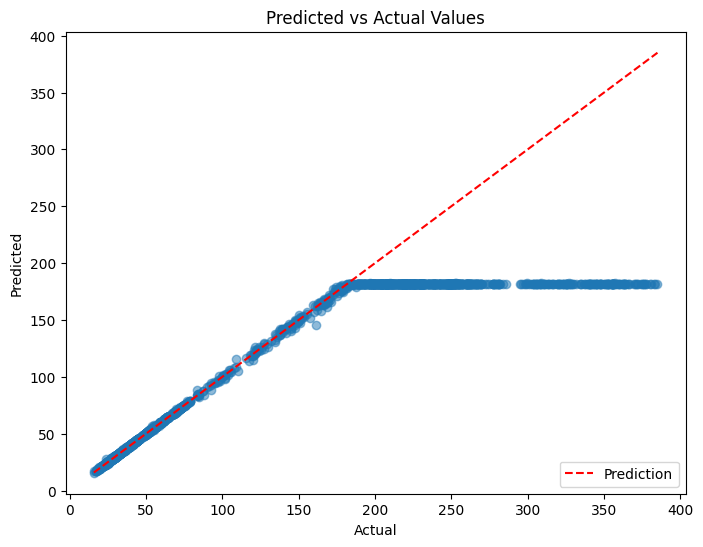

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Prediction')  
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Values")
plt.legend(loc='lower right')
plt.show()

In [50]:
X_with_const = sm.add_constant(X_train)

# Fit OLS model (Ordinary Least Squares)
model = sm.OLS(y_train, X_with_const)
results = model.fit()

# Print summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.265e+07
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        23:19:52   Log-Likelihood:                -2293.1
No. Observations:                5828   AIC:                             4596.
Df Residuals:                    5823   BIC:                             4629.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0319      0.011     -2.920      0.0